<a href="https://colab.research.google.com/github/alvinrach/SmartFarmingTemporaryTransit/blob/main/05_processing_data_04_3_3_alv_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install PyMySQL

# import library
import json
from sqlalchemy import create_engine
import pandas as pd

# open connection to the db
json_path = '/content/drive/MyDrive/lppm-itb-iot-anomaly/paper/config_colab.json'
# json_path = './config.json'

with open(json_path) as json_file:
    config = json.load(json_file)

db_connection_str = "mysql+pymysql://{mysql_user}:{mysql_password}@{mysql_host}/{mysql_db}".format(
mysql_user = config['database']['username'], 
mysql_password = config['database']['password'],
mysql_host = config['database']['host'],
mysql_db = config['database']['databasename']
    
)
db_connection = create_engine(db_connection_str)

     |████████████████████████████████| 43 kB 1.8 MB/s 


In [3]:
# Import Library

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [4]:
df = pd.read_sql('SELECT * FROM temp_suhus', con=db_connection)
df.head()

,id,app_id,dev_id,eui,batv,hum_sht,tempc_ds,tempc_sht,created_at,updated_at
0,1,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,NaN,36.3,NaN,36.20,2020-10-16 18:55:37,2020-10-16 18:55:37
1,2,lora-lht65,lht65-1,A84041000181B265,3.064,21.0,50.00,53.61,2020-10-16 19:02:02,2020-10-16 19:02:02
2,3,lora-lht65,lht65-1,A84041000181B265,3.066,45.4,29.31,34.68,2020-10-16 19:32:02,2020-10-16 19:32:02
3,4,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,NaN,71.6,NaN,25.20,2020-10-16 19:55:39,2020-10-16 19:55:39
4,5,lora-lht65,lht65-1,A84041000181B265,3.068,65.9,23.37,27.33,2020-10-16 20:02:01,2020-10-16 20:02:01


In [5]:
# convert timestamp
df['timestamp'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')

In [6]:
# Jumlah data
df.shape

(35829, 11)

In [7]:
df.isna().sum()

id               0
app_id           0
dev_id           0
eui              0
batv          6456
hum_sht          1
tempc_ds      6456
tempc_sht        1
created_at       0
updated_at       0
timestamp        0
dtype: int64

In [8]:
df['batv'].interpolate(method='linear', direction = 'forward', inplace=True)
df['hum_sht'].interpolate(method='linear', direction = 'forward', inplace=True)
df['tempc_ds'].interpolate(method='linear', direction = 'forward', inplace=True)
df['tempc_sht'].interpolate(method='linear', direction = 'forward', inplace=True)

In [9]:
df.isna().sum()

id            0
app_id        0
dev_id        0
eui           0
batv          1
hum_sht       0
tempc_ds      1
tempc_sht     0
created_at    0
updated_at    0
timestamp     0
dtype: int64

In [10]:
df = df.dropna()
df.isna().sum()

id            0
app_id        0
dev_id        0
eui           0
batv          0
hum_sht       0
tempc_ds      0
tempc_sht     0
created_at    0
updated_at    0
timestamp     0
dtype: int64

In [11]:
df.set_index(['timestamp'], inplace=False)

,id,app_id,dev_id,eui,batv,hum_sht,tempc_ds,tempc_sht,created_at,updated_at
timestamp,,,,,,,,,,
2020-10-16 19:02:02,2,lora-lht65,lht65-1,A84041000181B265,3.064,21.0,50.00,53.61,2020-10-16 19:02:02,2020-10-16 19:02:02
2020-10-16 19:32:02,3,lora-lht65,lht65-1,A84041000181B265,3.066,45.4,29.31,34.68,2020-10-16 19:32:02,2020-10-16 19:32:02
2020-10-16 19:55:39,4,sensecap-temperature,outdoor_temperature1,2CF7F12110700081,3.067,71.6,26.34,25.20,2020-10-16 19:55:39,2020-10-16 19:55:39
2020-10-16 20:02:01,5,lora-lht65,lht65-1,A84041000181B265,3.068,65.9,23.37,27.33,2020-10-16 20:02:01,2020-10-16 20:02:01
2020-10-16 20:32:02,6,lora-lht65,lht65-1,A84041000181B265,3.068,79.1,22.93,24.54,2020-10-16 20:32:02,2020-10-16 20:32:02
...,...,...,...,...,...,...,...,...,...,...
2021-07-19 11:21:31,35825,lora-lht65,lht65-1,A84041000181B265,3.057,47.1,34.31,38.66,2021-07-19 11:21:31,2021-07-19 11:21:31
2021-07-19 11:50:34,35826,lora-lht65,lht65-2,A84041000181B266,3.051,37.5,40.56,42.42,2021-07-19 11:50:34,2021-07-19 11:50:34
2021-07-19 11:51:15,35827,lora-lht65,lht65-3,A84041000181B267,3.054,37.2,40.50,43.38,2021-07-19 11:51:15,2021-07-19 11:51:15


In [12]:
df_ = df.resample('20Min', on='timestamp').mean()

In [13]:
df_ = df_[['batv', 'hum_sht', 'tempc_ds', 'tempc_sht']]
df_.head()

,batv,hum_sht,tempc_ds,tempc_sht
timestamp,,,,
2020-10-16 19:00:00,3.064,21.0,50.00,53.61
2020-10-16 19:20:00,3.066,45.4,29.31,34.68
2020-10-16 19:40:00,3.067,71.6,26.34,25.20
2020-10-16 20:00:00,3.068,65.9,23.37,27.33
2020-10-16 20:20:00,3.068,79.1,22.93,24.54


In [14]:
df_.isna().sum()

batv         5335
hum_sht      5335
tempc_ds     5335
tempc_sht    5335
dtype: int64

In [15]:
df_ = df_.dropna()

In [16]:
# key cell
df = df_.copy()

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(df)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

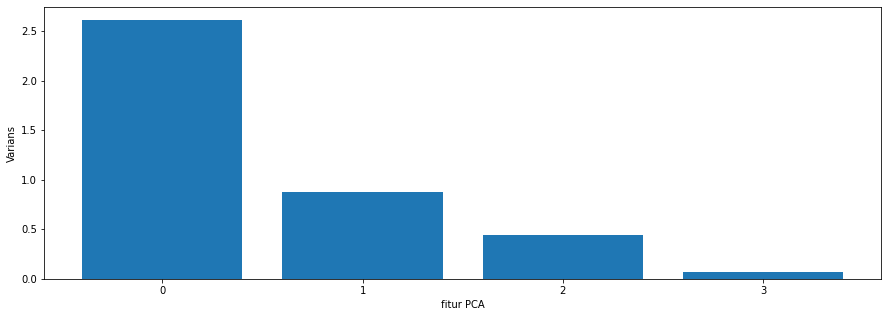

In [18]:
import matplotlib.pyplot as plt
features = range(pca.n_components_)
plt.figure(figsize=(15, 5))
plt.bar(features, pca.explained_variance_)
plt.xlabel('fitur PCA')
plt.ylabel('Varians')
plt.xticks(features)
plt.show()

In [19]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])
principalDf.head()

,pc1,pc2,pc3
0,-70.023284,22.285649,0.103539
1,-39.906106,0.644886,2.636102
2,-12.315823,-2.103875,-1.407648
3,-17.790323,-3.853257,2.172478
4,-4.391127,-3.121313,0.708409


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_data, test_data = train_test_split(principalDf, test_size=0.2, shuffle=False)

In [22]:
# normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
X_trainset = scaler.fit_transform(train_data)
X_testset = scaler.fit_transform(test_data)

In [23]:
# reshape input LSTM
X_trainset = X_trainset.reshape(X_trainset.shape[0], 1, X_trainset.shape[1])
print("Training data shape:", X_trainset.shape)
X_testset = X_testset.reshape(X_testset.shape[0], 1, X_testset.shape[1])
print("Test data shape:", X_testset.shape)

Training data shape: (11613, 1, 3)
Test data shape: (2904, 1, 3)


In [24]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [25]:
def gru_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = GRU(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = GRU(4, activation='relu', return_sequences=False)(L1) 
    L3 = RepeatVector(X.shape[1])(L2)
    output = TimeDistributed(Dense(X.shape[2]))(L3)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [26]:
# Membuat model lstm
model = gru_model(X_trainset)
#model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
gru (GRU)                    (None, 1, 16)             1008      
_________________________________________________________________
gru_1 (GRU)                  (None, 4)                 264       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 3)              15        
Total params: 1,287
Trainable params: 1,287
Non-trainable params: 0
_________________________________________________________________


In [27]:
# fit the model to the data
nb_epochs = 120
batch_size = 10
history = model.fit(X_trainset, X_trainset, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/120
1104/1104 [==============================] - 8s 4ms/step - loss: 0.0030 - val_loss: 1.7560e-04
Epoch 2/120
1104/1104 [==============================] - 4s 3ms/step - loss: 2.1422e-04 - val_loss: 8.0717e-05
Epoch 3/120
1104/1104 [==============================] - 4s 3ms/step - loss: 1.7447e-04 - val_loss: 3.3918e-05
Epoch 4/120
1104/1104 [==============================] - 4s 3ms/step - loss: 1.4440e-04 - val_loss: 1.1334e-05
Epoch 5/120
1104/1104 [==============================] - 4s 3ms/step - loss: 1.3706e-04 - val_loss: 1.0295e-05
Epoch 6/120
1104/1104 [==============================] - 4s 3ms/step - loss: 1.3045e-04 - val_loss: 9.4116e-06
Epoch 7/120
1104/1104 [==============================] - 4s 3ms/step - loss: 1.2655e-04 - val_loss: 8.1152e-06
Epoch 8/120
1104/1104 [==============================] - 4s 3ms/step - loss: 1.2328e-04 - val_loss: 2.3997e-05
Epoch 9/120
1104/1104 [==============================] - 4s 3ms/step - loss: 1.2056e-04 - val_loss: 3.4533e-05
Epoch

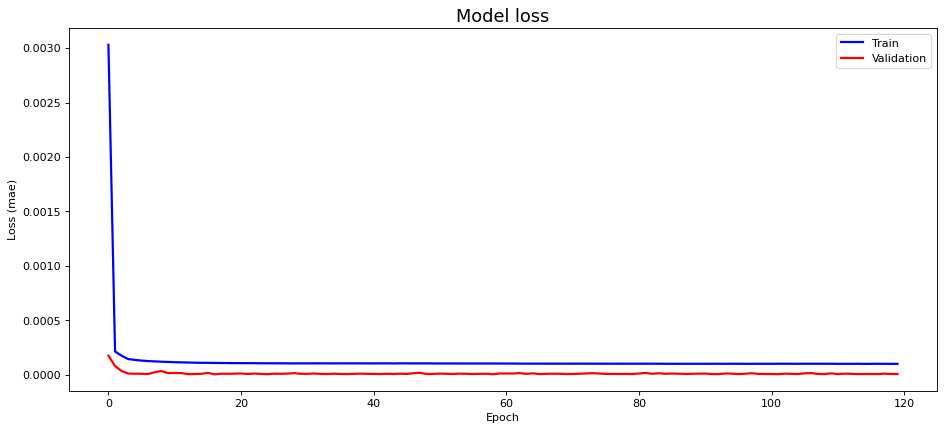

In [28]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE Train 0.0022753464893678697


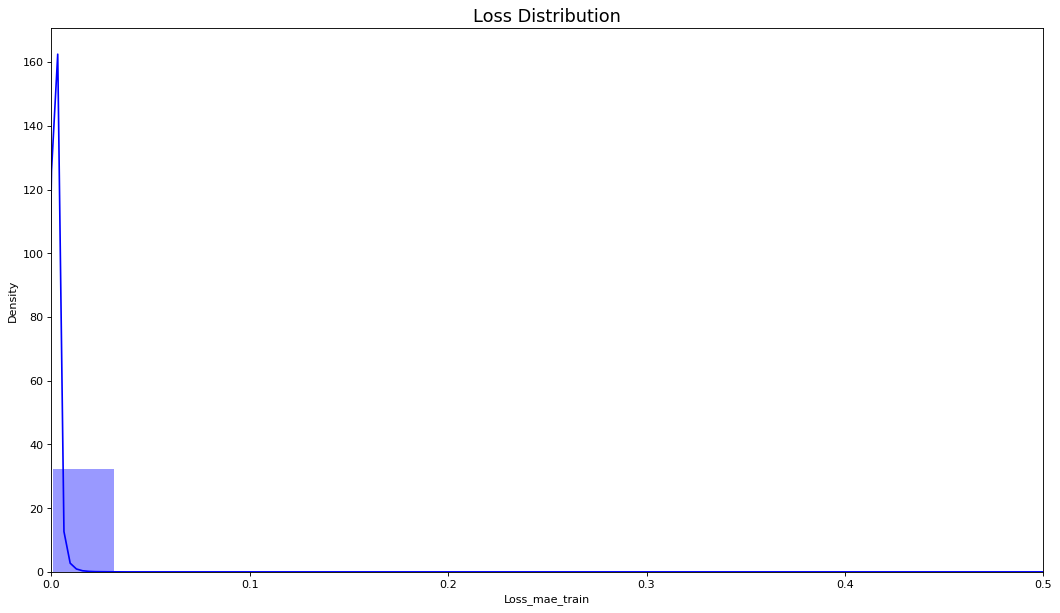

In [29]:
# distribusi lost train
import seaborn as sns
import numpy as np

X_pred = model.predict(X_trainset)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_data.columns)
X_pred.index = train_data.index

scored = pd.DataFrame(index=train_data.index)
Xtrainset = X_trainset.reshape(X_trainset.shape[0], X_trainset.shape[2])
scored['Loss_mae_train'] = np.mean(np.abs(X_pred-Xtrainset), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae_train'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])
print('MSE Train', scored['Loss_mae_train'].mean())

In [30]:
X_prediction = scaler.inverse_transform(X_pred)
output_ = pd.DataFrame(X_prediction, columns = ['pc1', 'pc2', 'pc3'])
output_.head(15)

,pc1,pc2,pc3
0,-54.745979,-10.576774,-2.688898
1,-53.148083,-12.108760,-2.482612
2,-51.611160,-12.168282,-2.620995
3,-52.130215,-12.445994,-2.503325
4,-51.539524,-12.374008,-2.579105
5,-50.641953,-12.190474,-2.711917
6,-51.335892,-12.261573,-2.626098
7,-42.332901,-6.316739,-4.935750
8,-51.285633,-12.291739,-2.623903
9,-51.086826,-12.147976,-2.677879


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE Test 0.4097496006019563


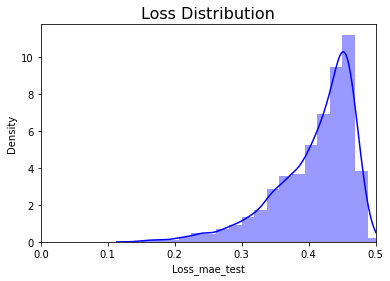

In [31]:
# calculate the loss on the test set
X_pred = model.predict(X_testset)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_data.columns)
X_pred.index = test_data.index

data = pd.DataFrame(index=test_data.index)
Xtest = X_testset.reshape(X_testset.shape[0], X_testset.shape[2])

data['Loss_mae_test'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
#data['Threshold'] = 0.371325511752544
#data['Anomaly'] = data['Loss_mae_test'] > data['Threshold']
#data.head()
#plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(data['Loss_mae_test'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])
print('MSE Test', data['Loss_mae_test'].mean())

In [32]:
X_prediction = scaler.inverse_transform(X_pred)
output = pd.DataFrame(X_prediction, columns = ['pc1', 'pc2', 'pc3'])
output.head(15)

,pc1,pc2,pc3
0,-37.524895,-12.352262,-3.975427
1,-37.889462,-11.893605,-4.048485
2,-37.492893,-12.392525,-3.969014
3,-37.084751,-12.906005,-3.887223
4,-37.495274,-12.389525,-3.969492
5,-37.147465,-12.827100,-3.899792
6,-36.757408,-13.317826,-3.821626
7,-37.162460,-12.808236,-3.902797
8,-36.896496,-13.142846,-3.849498
9,-36.724743,-13.358922,-3.815080


In [33]:
from sklearn.mixture import GaussianMixture

data = output_[['pc1', 'pc2', 'pc3']]
gmm = GaussianMixture(n_components = 2) 

gmm.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [34]:
output_['anomaly'] = gmm.predict(data)

In [35]:
output_['anomaly'].value_counts()

0    6997
1    4616
Name: anomaly, dtype: int64

In [36]:
from sklearn.metrics import silhouette_samples, silhouette_score
print("gmm: silhouttte: ", silhouette_score(data, output_['anomaly']))

gmm: silhouttte:  0.5943847


In [37]:
output_.head()

,pc1,pc2,pc3,anomaly
0,-54.745979,-10.576774,-2.688898,1
1,-53.148083,-12.108760,-2.482612,1
2,-51.611160,-12.168282,-2.620995,1
3,-52.130215,-12.445994,-2.503325,1
4,-51.539524,-12.374008,-2.579105,1


In [38]:
principalDf = output_[['pc1', 'pc2', 'pc3', 'anomaly']]

In [39]:
principalDf.head()

,pc1,pc2,pc3,anomaly
0,-54.745979,-10.576774,-2.688898,1
1,-53.148083,-12.108760,-2.482612,1
2,-51.611160,-12.168282,-2.620995,1
3,-52.130215,-12.445994,-2.503325,1
4,-51.539524,-12.374008,-2.579105,1


In [40]:
import numpy as np

# tempc-sht - inlier feature 1,  tempc_ds - inlier feature 2, hum_sht - inlier feature 3
inliers_pc1 = np.array(principalDf['pc1'][principalDf['anomaly'] == 0]).reshape(-1,1)
inliers_pc2 = np.array(principalDf['pc2'][principalDf['anomaly'] == 0]).reshape(-1,1)
inliers_pc3 = np.array(principalDf['pc3'][principalDf['anomaly'] == 0]).reshape(-1,1)
    
# tempc-sht - inlier feature 1,  tempc_ds - inlier feature 2, hum_sht - inlier feature 3
outliers_pc1 = principalDf['pc1'][principalDf['anomaly'] == 1].values.reshape(-1,1)
outliers_pc2 = principalDf['pc2'][principalDf['anomaly'] == 1].values.reshape(-1,1)
outliers_pc3 = principalDf['pc3'][principalDf['anomaly'] == 1].values.reshape(-1,1)

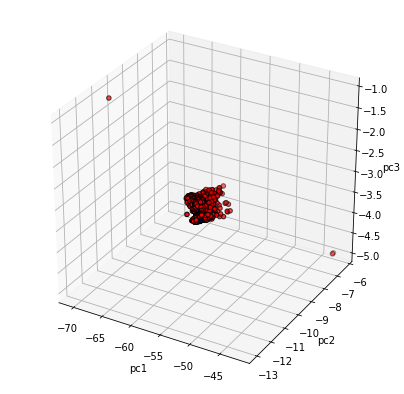

In [41]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
ax.scatter(inliers_pc1, inliers_pc2, inliers_pc3, c='blue',s=20, edgecolor='k')
ax.scatter(outliers_pc1, outliers_pc2, outliers_pc3, c='red',s=20, edgecolor='k')
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3');
pyplot.show()

In [42]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2) 

gmm.fit(output[['pc1', 'pc2', 'pc3']])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [43]:
output['anomaly'] = gmm.predict(output[['pc1', 'pc2', 'pc3']])

In [44]:
data_1 = output[['pc1', 'pc2', 'pc3']]

In [45]:
from sklearn.metrics import silhouette_samples, silhouette_score
print("gmm: silhouttte: ", silhouette_score(data_1, output['anomaly']))

gmm: silhouttte:  0.67552865


In [46]:
output_

,pc1,pc2,pc3,anomaly
0,-54.745979,-10.576774,-2.688898,1
1,-53.148083,-12.108760,-2.482612,1
2,-51.611160,-12.168282,-2.620995,1
3,-52.130215,-12.445994,-2.503325,1
4,-51.539524,-12.374008,-2.579105,1
...,...,...,...,...
11608,-51.190346,-12.140261,-2.669441,0
11609,-51.240978,-12.166572,-2.658148,0
11610,-51.197571,-12.220408,-2.649634,0
11611,-51.090900,-12.201838,-2.664646,0


In [47]:
output

,pc1,pc2,pc3,anomaly
0,-37.524895,-12.352262,-3.975427,1
1,-37.889462,-11.893605,-4.048485,1
2,-37.492893,-12.392525,-3.969014,1
3,-37.084751,-12.906005,-3.887223,1
4,-37.495274,-12.389525,-3.969492,1
...,...,...,...,...
2899,-64.099007,-7.140553,-2.586696,0
2900,-42.328278,-6.317168,-4.936172,0
2901,-61.440971,-7.071668,-2.869574,0
2902,-64.720619,-7.199216,-2.515197,0


In [48]:
df['anomaly'] = pd.concat((output_.anomaly,output.anomaly)).values

In [49]:
df

,batv,hum_sht,tempc_ds,tempc_sht,anomaly
timestamp,,,,,
2020-10-16 19:00:00,3.064000,21.000000,50.000000,53.610000,1
2020-10-16 19:20:00,3.066000,45.400000,29.310000,34.680000,1
2020-10-16 19:40:00,3.067000,71.600000,26.340000,25.200000,1
2020-10-16 20:00:00,3.068000,65.900000,23.370000,27.330000,1
2020-10-16 20:20:00,3.068000,79.100000,22.930000,24.540000,1
...,...,...,...,...,...
2021-07-19 10:40:00,3.051667,43.866667,35.873333,40.393333,0
2021-07-19 11:00:00,3.050000,52.600000,38.030000,32.900000,0
2021-07-19 11:20:00,3.052667,42.700000,37.850000,40.670000,0


In [50]:
# key cell
df1=df.copy()

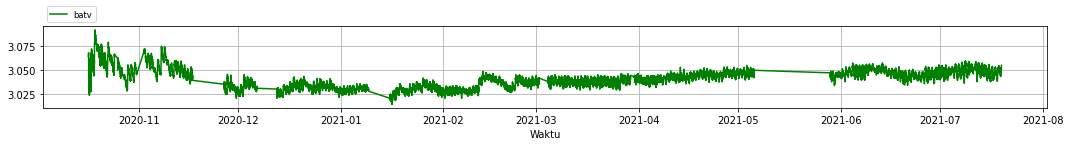

In [56]:
# Visualisasi data menggunakan metode statistika
import matplotlib.pyplot as plt
anomali = df1.loc[df1["anomaly"] == 1]
plt.figure(figsize=(18,1.5))
plt.plot(df1["batv"], color='green', label='batv')
# plt.plot(anomali["batv"], linestyle='none', marker='o', color='red', markersize=12, label='Anomaly')
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('batv.png', bbox_inches='tight')
plt.show()

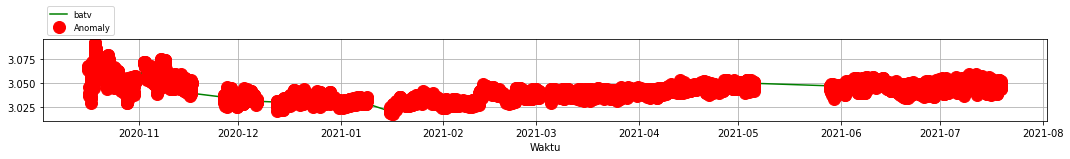

In [54]:
# Visualisasi data menggunakan metode statistika
import matplotlib.pyplot as plt
anomali = df1.loc[df1["anomaly"] == 1]
plt.figure(figsize=(18,1.5))
plt.plot(df1["batv"], color='green', label='batv')
plt.plot(anomali["batv"], linestyle='none', marker='o', color='red', markersize=12, label='Anomaly')
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('batv.png', bbox_inches='tight')
plt.show()

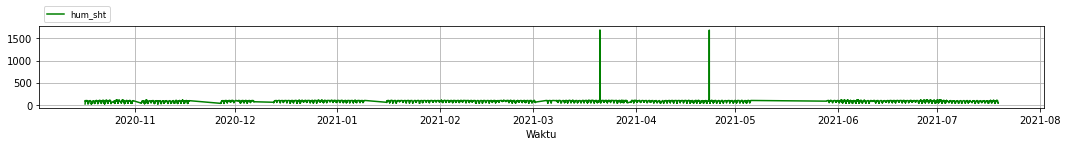

In [57]:
# Visualisasi data menggunakan metode statistika
import matplotlib.pyplot as plt
anomali = df1.loc[df1["anomaly"] == 1]
plt.figure(figsize=(18,1.5))
plt.plot(df1["hum_sht"], color='green', label='hum_sht')
# plt.plot(anomali["hum_sht"], linestyle='none', marker='o', color='red', markersize=12, label='Anomaly')
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('hum_sht.png', bbox_inches='tight')
plt.show()

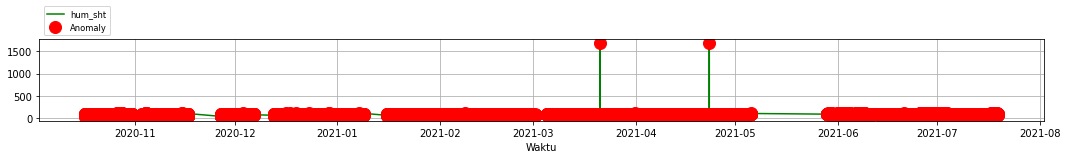

In [53]:
# Visualisasi data menggunakan metode statistika
import matplotlib.pyplot as plt
anomali = df1.loc[df1["anomaly"] == 1]
plt.figure(figsize=(18,1.5))
plt.plot(df1["hum_sht"], color='green', label='hum_sht')
plt.plot(anomali["hum_sht"], linestyle='none', marker='o', color='red', markersize=12, label='Anomaly')
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('hum_sht.png', bbox_inches='tight')
plt.show()

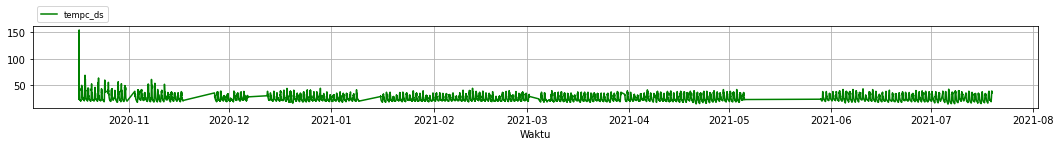

In [58]:
# Visualisasi data menggunakan metode statistika
import matplotlib.pyplot as plt
anomali = df1.loc[df1["anomaly"] == 1]
plt.figure(figsize=(18,1.5))
plt.plot(df1["tempc_ds"], color='green', label='tempc_ds')
# plt.plot(anomali["tempc_ds"], linestyle='none', marker='o', color='red', markersize=12, label='Anomaly')
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('tempc_ds.png', bbox_inches='tight')
plt.show()

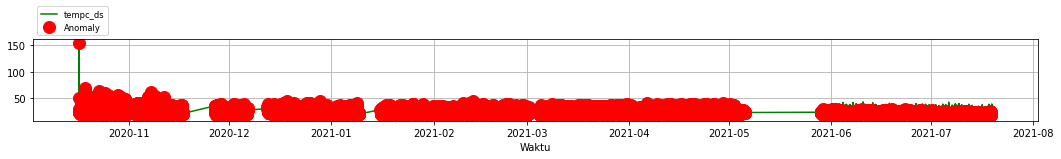

In [52]:
# Visualisasi data menggunakan metode statistika
import matplotlib.pyplot as plt
anomali = df1.loc[df1["anomaly"] == 1]
plt.figure(figsize=(18,1.5))
plt.plot(df1["tempc_ds"], color='green', label='tempc_ds')
plt.plot(anomali["tempc_ds"], linestyle='none', marker='o', color='red', markersize=12, label='Anomaly')
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('tempc_ds.png', bbox_inches='tight')
plt.show()

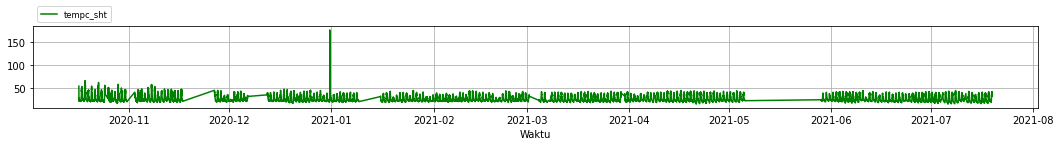

In [59]:
# Visualisasi data menggunakan metode statistika
import matplotlib.pyplot as plt
anomali = df1.loc[df1["anomaly"] == 1]
plt.figure(figsize=(18,1.5))
plt.plot(df1["tempc_sht"], color='green', label='tempc_sht')
# plt.plot(anomali["tempc_sht"], linestyle='none', marker='o', color='red', markersize=12, label='Anomaly')
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('tempc_sht.png', bbox_inches='tight')
plt.show()

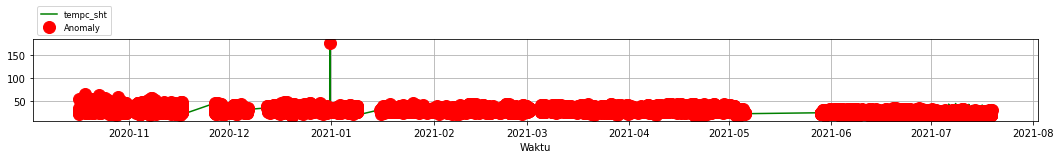

In [60]:
# Visualisasi data menggunakan metode statistika
import matplotlib.pyplot as plt
anomali = df1.loc[df1["anomaly"] == 1]
plt.figure(figsize=(18,1.5))
plt.plot(df1["tempc_sht"], color='green', label='tempc_sht')
plt.plot(anomali["tempc_sht"], linestyle='none', marker='o', color='red', markersize=12, label='Anomaly')
plt.xlabel('Waktu')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.grid(True)
plt.savefig('tempc_sht.png', bbox_inches='tight')
plt.show()